In [1]:
import implementations_sk
import numpy as np
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
import branca.colormap as cm
import math
import folium
from bs4 import BeautifulSoup
import requests
%matplotlib inline

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
from importlib import reload
reload(implementations_sk)
from implementations_sk import *

**Questions to Answer**

**1.** Which are the most cited patents (by other US patents), within the field of AI?

**2.** How much AI related patents granted through years and what its the percentage? We know that from common knowledge AI related researches increased and decreased agin in past decades, can we observe this situation by analysing the number of patents through years (in 1900s)? We also know that AI is one of the most popular area of research nowadays, will these popularity will also fade away like it has on the past or this time the characteristic of the popularity trend is different? 

**3.** Who are the most prolific inventors?

**4.** Which companies are holding most AI patents? 

**5.** Which countries have the most patents related to artificial intelligence? 

**6.** Is there a relationship between investing AI researches and being among top companies (according to  Fortune 500 list)? 

**7.** Considering that Putin recently said “the nation that leads in AI will be the ruler of the world”. What is the relationship between number AI related patents and the rank of countries’ defense industry?

First, we gathered all the patents related to AI.

Keywords related to Artificla Intelligence has been gathered from different sources into "ai_keywords.txt".

In [4]:
keywords = set()

f = open("data/ai_keywords.txt")
for line in f.readlines():
    keywords.add(line.strip('\n'))

Initialize two dictionaries, one for counting the total number patents and one for keeping track the actual informations of AI related patents. We are going to use total number of patents to calculate the percentage of AI related patents throughout years.

In [5]:
num_patents_by_year = dict()
ai_patents_by_year = dict()
for i in range(2018-1976):
    num_patents_by_year[str(1976+i)] = int()
    ai_patents_by_year[str(1976+i)] = pd.DataFrame()
    
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12",]

We iterate through years and months to get total number of patents.

In [ ]:
# Don't execute this cell, use the following saved pickle instead.
for year in num_patents_by_year:
    num_patents = 0
    for month in months:
        try:
            num_patents += get_num_patents(year,month)
        except Exception as error:
            print("An error occured on %s-%s. | %s"%(year,month,error))
    num_patents_by_year[year] = num_patents

pickle_out = open("data/num_patents_by_year.pickle","wb")
pickle.dump(num_patents_by_year, pickle_out)
pickle_out.close()

Since, gathering all the patent takes too long, we used pickle objects.

Following pickle object holds the information that how many AI patents granted in each year.

In [7]:
pickle_in = open("data/num_patents_by_year.pickle","rb")
num_patents_by_year = pickle.load(pickle_in)

IPC code "G06" corresponds to "Computing; Calculating; Counting". More information related to IPC can be found [here](http://www.wipo.int/classifications/ipc/en/).

In [8]:
ipc_list = [("G", "06", "-")]

We iterate through years and months to get total number of patents related to AI.

In [ ]:
# Don't execute this cell, use the following saved pickle instead.
for year in ai_patents_by_year:
    ai_patents = pd.DataFrame()
    for month in months:
        try:
            ai_patents_current = get_patents_by_keywords(keywords,ipc_list,year,month)
            ai_patents = pd.concat([ai_patents, ai_patents_current],ignore_index=True)
        except Exception as error:
            print("An error occured on %s-%s."%(year,month))
    ai_patents_by_year[year] = ai_patents

pickle_out = open("data/ai_patents_by_year.pickle","wb")
pickle.dump(ai_patents_by_year, pickle_out)
pickle_out.close()

It seem that for 2015, something went wrong and no patent has been granted under IPC category "G06". (We checked and the error were not caused by our code.) Note that error caused by the PatensView itself.

Following pickle object holds the information that actual AI patents granted in each year.

In [9]:
pickle_in = open("data/ai_patents_by_year.pickle","rb")
ai_patents_by_year = pickle.load(pickle_in)

In [10]:
ai_patents_by_year["2016"].head(3)

,patent_title,patent_number,patent_num_cited_by_us_patents,assignees,patent_date,inventors
0,Systems and methods for automated classificati...,9226654,0,"[{'assignee_country': 'US', 'assignee_organiza...",2016-01-05,"[{'inventor_first_name': 'Paul F.', 'inventor_..."
1,Data mining in a digital map database to ident...,9228844,0,"[{'assignee_country': 'NL', 'assignee_organiza...",2016-01-05,"[{'inventor_first_name': 'Robert', 'inventor_l..."
2,Causation isolation using a configuration item...,9229898,1,"[{'assignee_country': 'US', 'assignee_organiza...",2016-01-05,"[{'inventor_first_name': 'Amit Y.', 'inventor_..."


Before moving into answering research questions, we first, gathered all the patents in a single DataFrame. In addition to yearly AI patents "ai_patents_by_year", we also going to need all AI patents data in one dataframe.

In [11]:
all_ai_patents = pd.DataFrame()
for year in ai_patents_by_year:
    all_ai_patents = pd.concat([all_ai_patents, ai_patents_by_year[year]], ignore_index=True)

We cleaned the DataFrame to be able to see country, organiaztion, inventors and date more clearly.

Since different inventors could carry the same name, we are going to use their unique IDs to differentiate them.

In [12]:
inventor_id_name = dict()
for row in all_ai_patents["inventors"]:
    inventor_id = row[0]["inventor_id"]
    inventor_name = str(row[0]["inventor_first_name"]) + " " + str(row[0]["inventor_last_name"])
    inventor_id_name[inventor_id] = inventor_name

In [13]:
all_ai_patents = all_ai_patents.rename(columns={'patent_num_cited_by_us_patents': 'cited_by_others',}) 

all_ai_patents["country"] = all_ai_patents["assignees"].apply(lambda row: row[0]["assignee_country"])
all_ai_patents["organization"] = all_ai_patents["assignees"].apply(lambda row: row[0]["assignee_organization"])
all_ai_patents["inventor_id"] = all_ai_patents["inventors"].apply(lambda row: row[0]["inventor_id"])
all_ai_patents["inventor_name"] = all_ai_patents["inventor_id"].apply(lambda row: inventor_id_name[row])
all_ai_patents["year"] = all_ai_patents["patent_date"].apply(lambda row: int(row.split("-")[0]))
all_ai_patents["month"] = all_ai_patents["patent_date"].apply(lambda row: int(row.split("-")[1]))

all_ai_patents["cited_by_others"] = all_ai_patents["cited_by_others"].astype("int64")

all_ai_patents.index = all_ai_patents.patent_number
all_ai_patents = all_ai_patents.drop(columns=['assignees', 'inventors', 'patent_date', 'patent_number'])
all_ai_patents.head(3)

,patent_title,cited_by_others,country,organization,inventor_id,inventor_name,year,month
patent_number,,,,,,,,
3935562,Pattern recognition method and apparatus,14,None,None,3932839-1,Richard G. Stephens,1976,1
3936800,Pattern recognition system,95,None,None,3936800-1,Masakazu Ejiri,1976,2
3938089,Double read system for character recognition s...,15,US,Burroughs Corporation,3938089-1,Arvin D. McGregor,1976,2


This is the all purpose DataFrame, it constains all the informations that we are going to analyze about AI patents. Now, we can move onto answering research questions.

We wanted to start with a basic question.

### 1. Which are the most cited patents (by other US patents) within the field of AI?

In our initial analysis we observe that, the patent dataset has a field for number of times that a particular patent cited by other patents however, further anaylsis showed that this field based only on US patents. More clearly, the description of this field is that "Number of times the patent was cited by other US patents". Consequently, we don't have information about citations from other countries and therefore, decided to restrict the scope of this question into citation made only by US patents.

Note that actual patents are not only from US, just the number of citation that a particular patent have is calculated only by citation of other US patents.

In [14]:
top_patents = all_ai_patents.sort_values(by='cited_by_others', ascending=False)
top_patents = top_patents[["patent_title","cited_by_others", "year", "organization",\
                           "inventor_name", "country"]]

with pd.option_context('display.max_colwidth', -1):
    display(top_patents.head(20))

,patent_title,cited_by_others,year,organization,inventor_name,country
patent_number,,,,,,
5875108,Ergonomic man-machine interface incorporating adaptive pattern recognition based control system,849,1999,None,Steven M. Hoffberg,None
5867799,Information system and method for filtering a massive flow of information entities to meet user information classification needs,736,1999,None,Andrew K. Lang,None
5933822,Apparatus and methods for an information retrieval system that employs natural language processing of search results to improve overall precision,599,1999,Microsoft Corporation,Lisa C. Braden-Harder,US
6055573,Communicating with a computer based on an updated purchase behavior classification of a particular consumer,598,2000,"SuperMarkets Online, Inc.",Will H. Gardenswartz,US
5974396,Method and system for gathering and analyzing consumer purchasing information based on product and consumer clustering relationships,597,1999,"Moore Business Forms, Inc.",Michael W. Anderson,US
6157955,Packet processing system including a policy engine having a classification unit,542,2000,Intel Corporation,Pradip Shankar,US
6363160,Interface using pattern recognition and tracking,456,2002,Intel Corporation,Boon-Lock Yeo,US
4843562,Broadcast information classification system and method,442,1989,Broadcast Data Systems Limited Partnership,Stephen C. Kenyon,US
6330546,Risk determination and management using predictive modeling and transaction profiles for individual transacting entities,430,2001,"HNC Software, Inc.",Allen P. Jost,US


Looking at the names of top cited patents, they potentially, have a lots of area of use. Take for example, *"Predictive modeling of consumer financial behavior"* patent, this technology is clearly, highly beneficial for any kind of company that interests in financial behaviour of its consumers (which is pretty much any company). Therefore, the popularity of this patent and it is being highly used by other patents is quite expected as many other patent in this list.

It is also expected that most cited patents should be granted much earlier and this is the case for most of the top-cited patents including top 3 (all granted in 1999) however we also observe that there are some patents that are relatively new (e.g. 2002, 2011). This might be an indication of that innovations in this area still continues and there are many researches and technologies that are based on these patents.

Apart from citations by US patents, we don't have information about number of citations that a patent get by other patents (as stated earlier). This means that we don't have a global picture of patent citations and for this reason, we decided restrict this part of our study to only analyzing top cited patents (as we did above) and not further. Since our study is not country specific and analyzing citation data we have would only be related to US, we though that it doens't aligns with the purpose our study. 

Now, we move into more detailed analysis of AI patents.

### 2.1. How much AI related patents granted through years? 

### 2.2 We know that from common knowledge AI related researches increased then decreased in past decades (its popularity didn't hold up because of lack of data and computing power.  Can we observe this situation by analysing the number of AI patents through years? We also know that AI is one of the most popular area of research nowadays, will these popularity will also decline away like it did on the past or this time the characteristic of the popularity trend is different? 

First, we calculated the number of overall and AI patents granted on each year.

In [15]:
ai_num_patents_by_year_df = pd.DataFrame(columns=['year','number_of_ai_patents'])
num_patents_by_year_df = pd.DataFrame(columns=['year','number_of_patents'])
for year in ai_patents_by_year:
    ai_num_patents_by_year_df = ai_num_patents_by_year_df\
        .append({'year': year,'number_of_ai_patents': len(ai_patents_by_year[year])}, ignore_index=True)
    num_patents_by_year_df = num_patents_by_year_df\
        .append({'year': year,'number_of_patents': num_patents_by_year[year]}, ignore_index=True)
num_patents_by_year_df.head(3)

,year,number_of_patents
0,1976,70941
1,1977,69820
2,1978,70586


Since there were something wrong with the year 2005, we were not able to use data belongs to that year and, data for the year 2017 still is not complete. We decided to drop these two years from dataset in order to maintain the continuity of line graphs. We though that dropping them is right course of action both for representation and analysis of the data.

In [16]:
ai_num_patents_by_year_df = ai_num_patents_by_year_df[~ai_num_patents_by_year_df.year.isin(["2005","2017"])]
num_patents_by_year_df = num_patents_by_year_df[~num_patents_by_year_df.year.isin(["2005","2017"])]

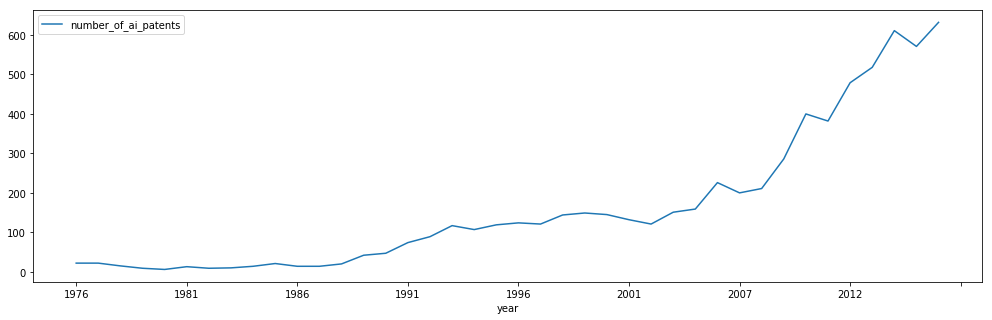

In [17]:
ai_num_patents_by_year_df.plot(x="year", y="number_of_ai_patents", figsize=(17,5),)

From this figure, it seems that there are two periods of time when number of AI patent rised which are 1986-1996 and 2006-2016. Other than these, the amount of patent seems pretty steady.  But since overall number of patents also rising over years, to be able to see the whole picture and make a more complete analysis, we also need to check the percentage of AI patents over all patents through years. 

In [18]:
merged_num_patent = pd.merge(ai_num_patents_by_year_df, num_patents_by_year_df, on="year")

merged_num_patent['ai_precentage'] =\
    merged_num_patent['number_of_ai_patents'] / merged_num_patent['number_of_patents'] * 100

merged_num_patent.head(3)

,year,number_of_ai_patents,number_of_patents,ai_precentage
0,1976,22,70941,0.0310117
1,1977,22,69820,0.0315096
2,1978,15,70586,0.0212507


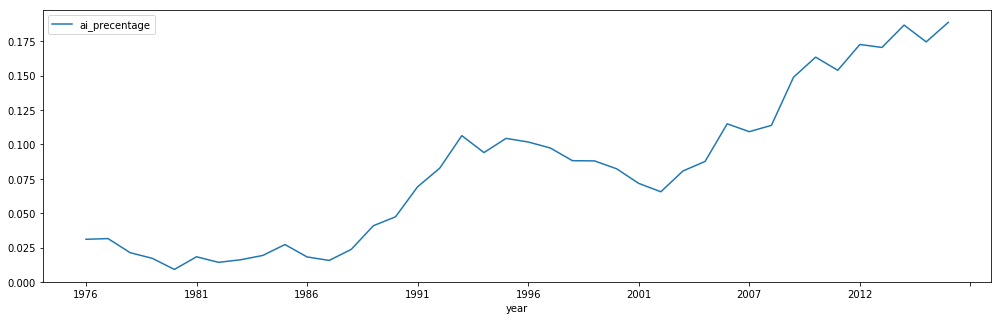

In [19]:
merged_num_patent.plot(x="year", y="ai_precentage", figsize=(17,5),)

There are couple of observations worth mentioning about these figures. **First** of all,  the graph starts with a decline from 1976. We already know that AI was popular field of research at 1960s (e.g. Artificial Neural Networks invented in this period.) and started to decline after that (mostly because of the lack of processing power and data). Although, we don't have data of 1960s, we can see that the graph starts with a steady line in 1976 then, rapid decline starting from 1977. It continues to decline for 3 years until it has the lowest value in 1980. The rate in 1977 is only reached again in 1989 which is 12 years lates.  So,we can derive that the line-graph's confirms our knowledge about the popularity of AI researches in 1960s. At this point, we though that it is also safe to think that percentage of AI patents is an indication the popularity of AI researches among others. **Another** interesting point is that percentage of AI patents rapidly rised from 1987 until 1994 then, stayed steady about 3 years and started to decline again. It continue to decline for 5 years, until 2002. Again, the rate of AI patents in 1997 is only reached after 10 years, around 2007. We can see that this trend is pretty similar to 1960s', it starts with a rapid increase, followed by a steady period then, a decrease for couple of years and in both situation, 13 years had to past before the rate come back to where it was. With the help of these trends, we can try to analyze the ***current situation***. We see that there is a dramatic increase on patent rates from 2002 to 2012 then, it stayed about the same rate with fluctuations. The characteristic that increasing rapidly and entering into steady phase is pretty similar to what we observed in last decades however it seems that the steady phase won't followed by a decline since the rates started to increase again in 2016. Although this might be an indication that popularity of AI related researches won't decline this time, like it did before, we still think that it is too early to infer that. The first two phases were similar to what has been observed in the past trends and it requires time (at least couple more years) to decide whether this time will be different or not.

It is clear that the AI researches are dramatically increased over 40 years, it was around *30 per/year with 0.03 percentage* overall patents and It is around *700 per/year with a percentage of 0.12* now.

We also curious about inventors with most patents.

### 3. Who are the most prolific inventors?

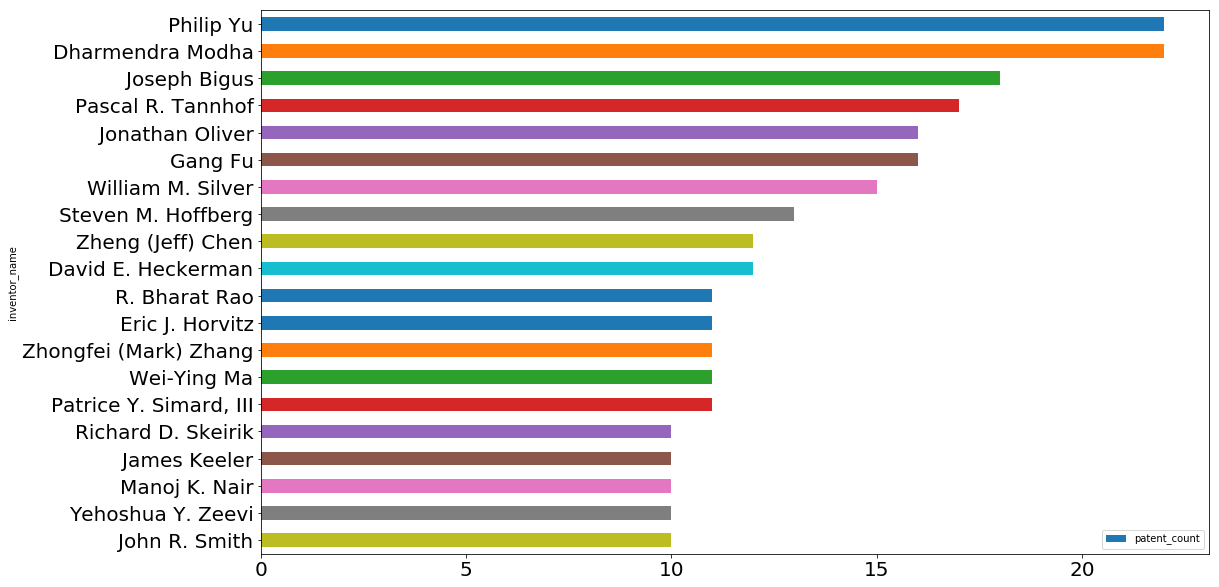

In [20]:
all_ai_patents_copy = all_ai_patents.copy()
all_ai_patents_copy = all_ai_patents_copy[["patent_title","inventor_id"]]\
                      .rename(columns={'patent_title': 'patent_count',})
all_ai_patents_copy["patent_count"] = 1
top_inventors = all_ai_patents_copy.groupby(['inventor_id'])\
                .sum()\
                .sort_values(by='patent_count', ascending=False)
        
top_inventors["inventor_name"] = top_inventors.index
top_inventors["inventor_name"] = top_inventors["inventor_name"].apply(lambda row: inventor_id_name[row])

top_inventors.head(20).plot.barh(x='inventor_name', y='patent_count', figsize=(17,10), fontsize=20).invert_yaxis()

There is not much to interpret about this table (since we are already analyzing related companies and countries in other parts of the study) but here are some information about top 2 AI patent holders which confirm that we are on the right track.

**Philip Yu** is an American computer scientist and Professor in Information Technology at the University of Illinois at Chicago, known for his work in the field of data mining.

**Dharmendra Modha** is an Indian American manager and lead researcher of the Cognitive Computing group at IBM Almaden Research Center. He is known for his pioneering works in Artificial Intelligence and Mind Simulation.

Now, we move into company-wise analysis.

### 4. Which companies are holding most AI patents?

We extract the information about top companies from our main dataframe "all_ai_patents".

In [21]:
all_ai_patents_copy = all_ai_patents.copy()
all_ai_patents_copy = all_ai_patents_copy[["patent_title","organization"]]\
                      .rename(columns={'patent_title': 'patent_count',})
all_ai_patents_copy["patent_count"] = 1
top_organizations = all_ai_patents_copy.groupby(['organization'])\
                .sum()\
                .sort_values(by='patent_count', ascending=False)

top_organizations["organization"] = top_organizations.index
top_organizations = top_organizations[["organization", "patent_count"]]
top_organizations.at["Microsoft Corporation", 'patent_count'] = 296 + 56
top_organizations = top_organizations[
    top_organizations.organization != "MICROSOFT TECHNOLOGY LICENSING, LLC"]
top_organizations.index = range(1,len(top_organizations)+1)

with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1):
    display(top_organizations.head(3))

,organization,patent_count
1,International Business Machines Corporation,780
2,Microsoft Corporation,352
3,Google Inc.,252


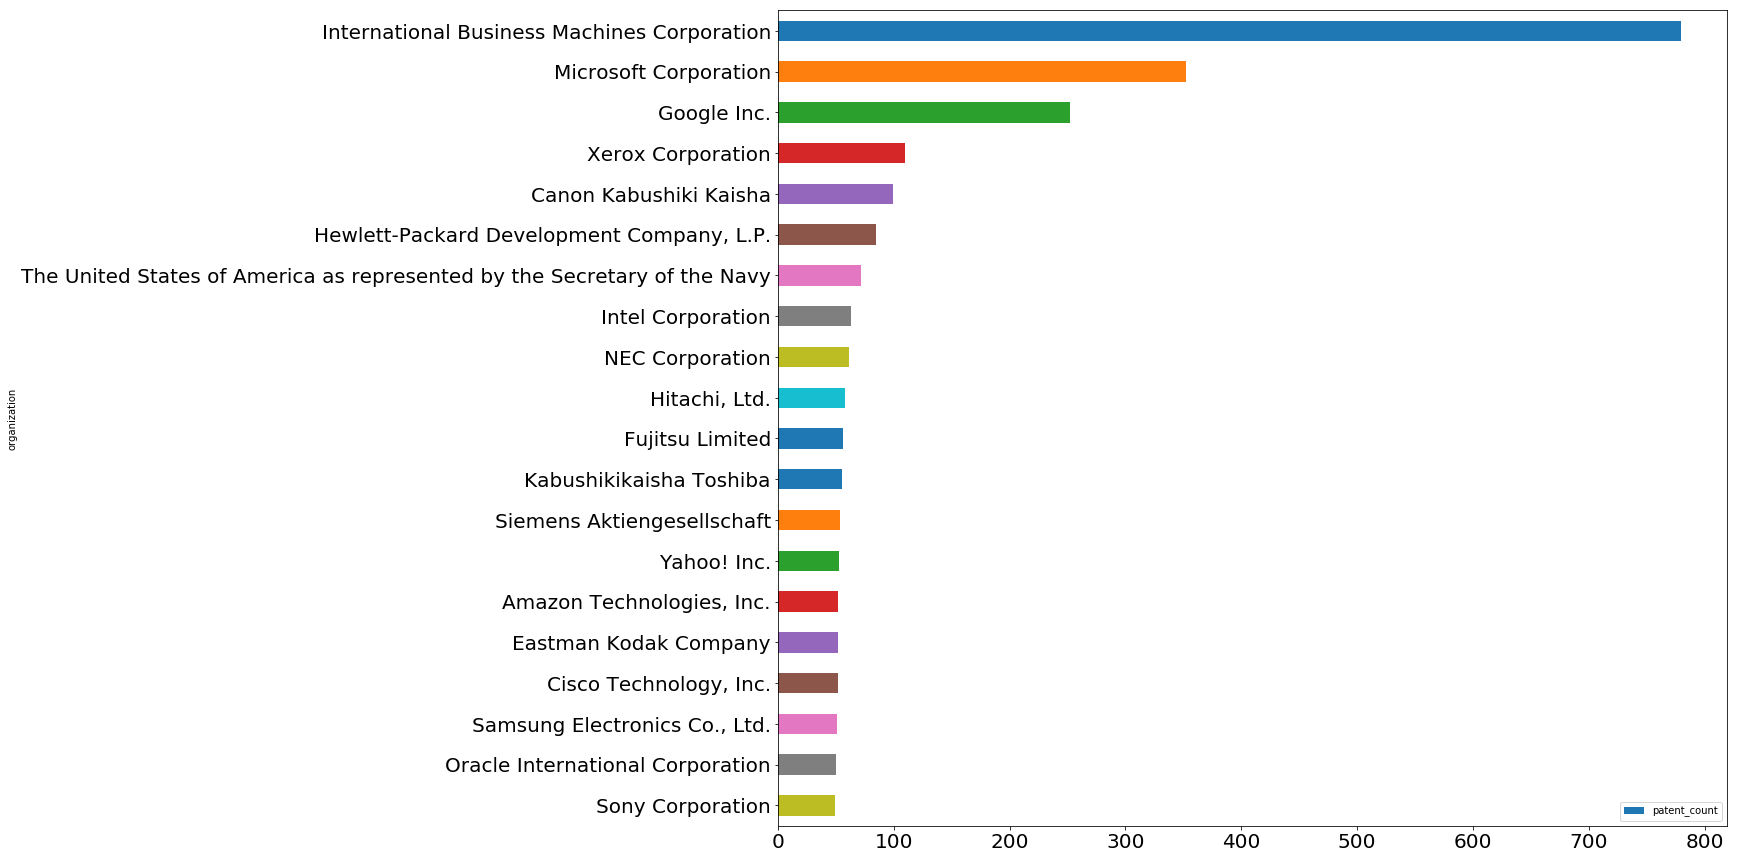

In [22]:
top_organizations.head(20).plot.barh(x='organization', y='patent_count', figsize=(17,15), fontsize=20).invert_yaxis()

**[Interpretation of the Figure]**

After companies, we wanted analyze countries too.

### 5. Which countries have the most patents related to artificial intelligence? 

We create a dictionary to keep track of how much AI patents each country has through years.

In [23]:
ai_patent_by_country = dict()
for country in all_ai_patents.country.unique():
    ai_patent_by_country[country] = dict()
    for i in range(2018-1976):
        year = 1976+i
        if year != 2005 and year != 2017:
            ai_patent_by_country[country][year] = int()

for country, year in zip(all_ai_patents["country"], all_ai_patents["year"]):
    if year != 2005 and year != 2017:
        ai_patent_by_country[country][year] += 1

del ai_patent_by_country[None]
del ai_patent_by_country["City of\""]

We created a Dataframe with a row for each country and a column for each year.

In [24]:
country_year_df =\
pd.DataFrame([(country,year,value) for country,v in ai_patent_by_country.items() for year,value in v.items()],\
             columns = ['country','year','patent_num'])
country_year_df = country_year_df.pivot(index='country', columns='year', values='patent_num')
country_year_df.head(3)

year,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,,,,,,,,,
AE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
AU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,1,4,2,1,2


We though that stacked bar chart would be a good indication of both to see which countries hold the most AI patents and observe change in number of AI patent through years.

<a id='country_patents'></a>

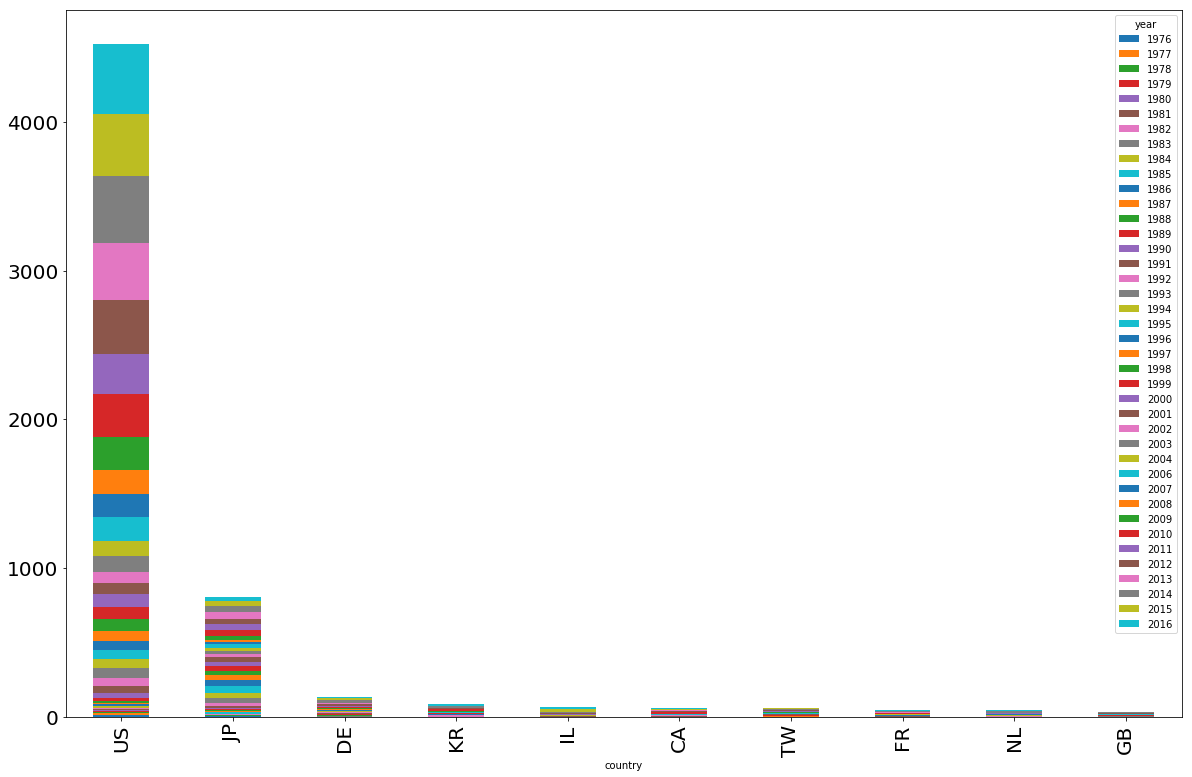

In [25]:
country_year_df_copy = country_year_df.copy()
country_year_df_copy['total'] = country_year_df_copy.apply(sum, axis=1)
clean_df =\
    country_year_df_copy.sort_values(by='total', ascending=False).drop('total',axis=1)
clean_df.head(10).plot.bar(stacked=True, fontsize=20, figsize=(20,13));

**[INTEPRETATION OF THE FIGURE]**

To further study, we wanted to analyze the evolution of AI related patents by an **interactive visualization**. You can choose the year and figure displays top countries that have the most AI patents (using only the AI patent until choosen year from 1976). There is also a play button to see the evolution of the graph.

In [26]:
years = list()
for i in range(2018-1976):
    year = 1976+i
    if year != 2005 and year != 2017:
        years.append(year)

def draw_until_year(until_year):
    columns_drop = list()
    for year in years:
        if year > until_year:
            columns_drop.append(year)
    country_year_df_copy = country_year_df.copy()
    country_year_df_copy = country_year_df_copy.drop(columns=columns_drop)
    country_year_df_copy['total'] = country_year_df_copy.apply(sum, axis=1)
    clean_df = country_year_df_copy.sort_values(by='total', ascending=False).drop('total',axis=1).head(10)
    clean_df.plot.bar(stacked=True, fontsize=20, figsize=(20,13));
    plt.show()

In [27]:
slider = widgets.IntSlider(
    value=1976,
    min=1976,
    max=2016,
    step=1,
    disabled=False,
)

play = widgets.Play(
    interval=2000,
    value=1976,
    min=1976,
    max=2016,
    step=1,
    description="Press play",
    disabled=False
)

visual = widgets.interactive(draw_until_year, until_year=slider)
widgets.jslink((play, 'value'), (slider, 'value'))
widgets.HBox([play, visual])

HBox(children=(Play(value=1976, description='Press play', interval=2000, max=2016, min=1976), interactive(children=(IntSlider(value=1976, description='until_year', max=2016, min=1976), Output()), _dom_classes=('widget-interact',))))

To enable required tools for interactive visualization check [here](https://stackoverflow.com/a/38001920). And it a bit slow so we set the interval to 2 seconds.

Note that this visulization doesn't work on Github since it needs to load data as we interact.

**[INTEPRETATION OF THE FIGURE]**

To be able to see more clearly which part of the world hold the most AI patent, we wanted to draw choropleth map of the AI patent distribution around the world.

In [28]:
country_num = pd.DataFrame(country_year_df_copy["total"])

max_count = country_num['total'].max()
colormap = cm.linear.PuBu.scale(0, round(math.log(max_count)))

log_total = list(map(lambda x: math.log(x) if (x > 0) else 0 , country_num['total']))
country_num['log_total'] = log_total

In [29]:
def get_color(feature, colors):
    if (feature['properties']['iso_a2'] in colors.keys()):
        return colors[feature['properties']['iso_a2']]
    else:
        return '#ffffff'

In [30]:
patents_dict = country_num.drop(columns=["total"])["log_total"]
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

countries_geo_path = 'data/custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': get_color(feature, color_dict),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

colormap = cm.linear.PuBu.scale(0, 170000).to_step(50)
colormap.caption = 'Number of AI Patents'
m.add_child(colormap)

m.save('data/ai_world.html')

Here is an overview of the distribution of AI patents over the world. 

The **interactive map** can be accessed from [here](https://skagankose.github.io/ada_fall_2017/ai_world.html).

![Image](data/ai_world.png)

At this point of our research we were curious about whether or not  investing on AI research as a company or a country would actually benefit you. For this purpose we first, wanted compare number of AI patent (and it ratio) that companies have and its actual rankings.

### 6. Is there a relationship between investing AI researches and being among top companies (according to  Fortune 500 list)? 

In order to find which companies investing AI researchers in which proportion, we decided to calculate raio of AI patents among all other patents that a company have for each company. We already have the information about overall number of patents for each company (from the first part of our research).

In [31]:
pickle_in = open("data/total_patents_all.pickle","rb")
total_patents_all = pickle.load(pickle_in)

In [32]:
total_patent_all = pd.DataFrame(list(total_patents_all.items()))
total_patent_all.columns = ["organization","total_patent"]
total_patent_all.index = total_patent_all.organization
total_patent_all.at["Microsoft Corporation", 'total_patent'] = 29694 + 5903
total_patent_all = total_patent_all[
    total_patent_all.organization != "MICROSOFT TECHNOLOGY LICENSING, LLC"]
total_patent_all.index = range(1,len(total_patent_all)+1)
total_patent_all.head(3)

,organization,total_patent
1,International Business Machines Corporation,111916
2,"Samsung Electronics Co., Ltd.",72139
3,Canon Kabushiki Kaisha,65779


Now, we can calculate the percentage since we have both the number of AI related patents and all other patents. For some companies, it is the case that they have couple of patents and they are related to AI so, percentage of AI patent ends up being 100%. Since, such companies doesn't our concern and we only insterested in big companies in this study, we decided to remove all the companies that has less than 1300 patents overall. Basically, we are interested in big companies that are devoted some part of their resources onto AI researches and the corelation between this situation and their ranks. (Small companies 

In [33]:
total_patent_all_gte = total_patent_all[total_patent_all.total_patent > 1300]
total_vs_ai = top_organizations.merge(total_patent_all_gte, on="organization")

total_vs_ai.columns = ["organization", "ai_patents", "total_patents"]
total_vs_ai["ai_percentage"] = total_vs_ai["ai_patents"] / total_vs_ai["total_patents"] * 100
top_ai_ratio = total_vs_ai.sort_values(by='ai_percentage', ascending=False)
top_ai_ratio.index = range(1,len(top_ai_ratio)+1)

with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1,):
    display(top_ai_ratio.head(3))

,organization,ai_patents,total_patents,ai_percentage
1,Yahoo! Inc.,53,2385,2.222222
2,"Siemens Medical Solutions USA, Inc.",30,1703,1.761597
3,Google Inc.,252,14371,1.753531


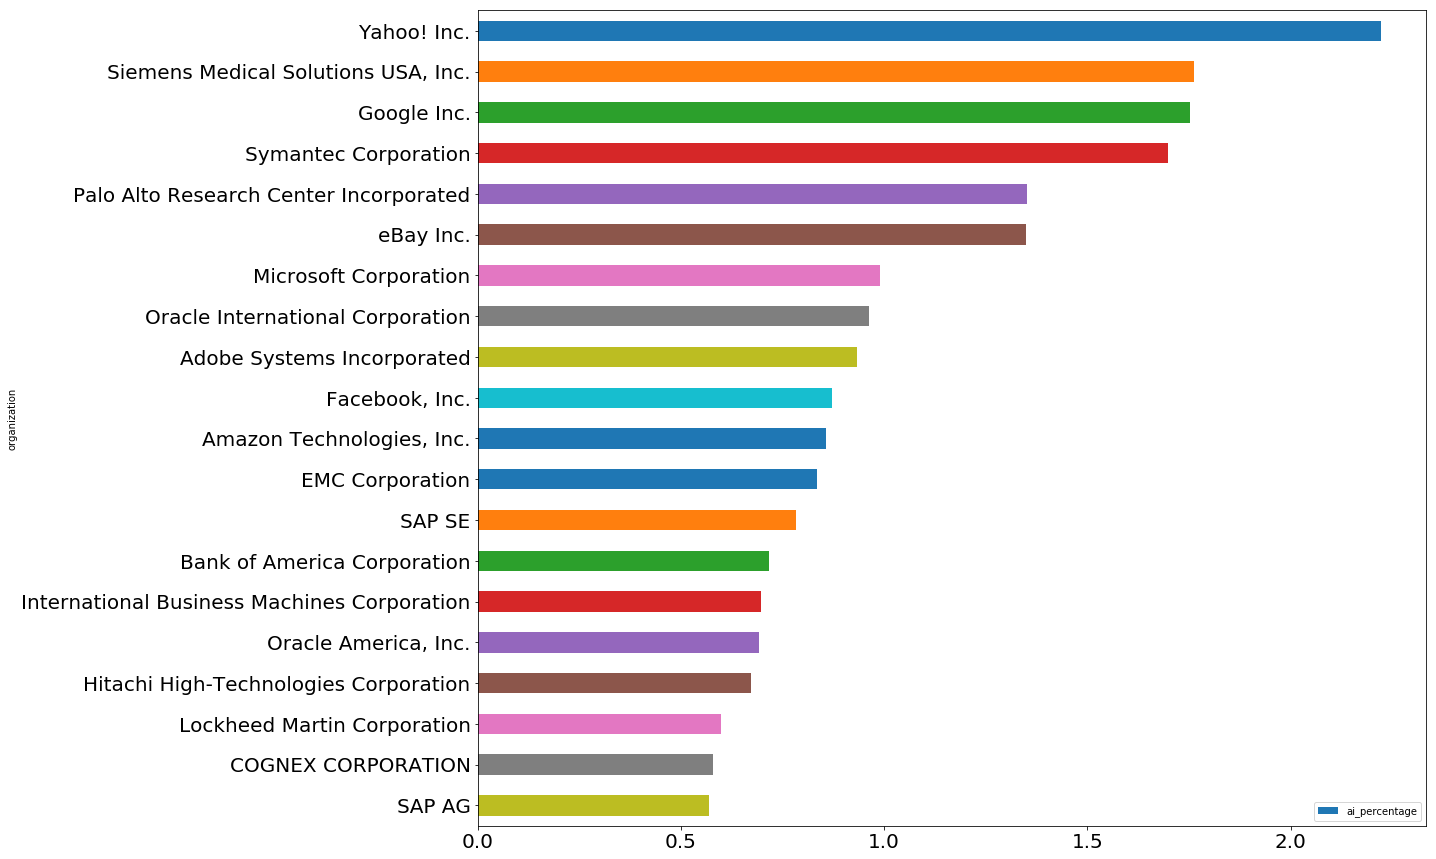

In [34]:
top_ai_ratio.head(20).plot.barh(x='organization', y='ai_percentage', figsize=(17,15), fontsize=20).invert_yaxis()

This figure shows the rankings of companies based on how much of its patents are related to AI meaning that how much of its resources devoted to AI researches.

We wanted to see whether or not investing AI research would end up increasing the rank of a company. For this purpose we decided to match top companies we found (by the number of AI patents) wıth the companies in Fortune 500 list.

Note that within Fortune 500 list, we only take companies related to computer software and information systems into consideration since it is highly probable that only these companies made researches related to AI.

In [ ]:
# Don't execute this cell, use the following saved pickle instead.
page = requests.get("https://en.wikipedia.org/wiki/\
                     List_of_Fortune_500_computer_software_and_information_companies")
soup = BeautifulSoup(page.content, 'html.parser')

top_fortune = dict()
for row in soup.findAll("tr"):
    company = str(row).split(">")[3].strip("</a")
    rank = str(row).split(">")[8].strip("</td")
    
    try:
        top_fortune[company]= int(rank)
    except:
        top_fortune[company]= None

del top_fortune['\n<th']

for rank, company in enumerate(sorted(top_fortune, key=top_fortune.get)):
    top_fortune[company] = rank+1

pickle_out = open("data/top_fortune.pickle","wb")
pickle.dump(top_fortune, pickle_out)
pickle_out.close()

In [35]:
pickle_in = open("data/top_fortune.pickle","rb")
top_fortune = pickle.load(pickle_in)

In [36]:
top_fortune = pd.DataFrame(list(top_fortune.items()))
top_fortune.columns = ["organization","rank"]
top_fortune = top_fortune.sort_values(by='rank')
top_fortune.index = range(1,len(top_fortune)+1)

In order to compare companies, we need to standardize the names in Fortune list. We created a dictionary for that purpose.

In [37]:
pickle_in = open("data/standardized_company_names.pickle","rb")
standardized_company_names = pickle.load(pickle_in)

In [38]:
def standardize_name(company):
    try:
        return standardized_company_names[company]
    except:
        return None
top_fortune.organization = top_fortune.organization.apply(standardize_name)
top_fortune = top_fortune.dropna()
top_fortune.index = range(1,len(top_fortune)+1)
with pd.option_context('display.max_rows', None, 'display.max_colwidth', -1,):
    display(top_fortune.head(3))

,organization,rank
1,Apple Inc.,1
2,"Amazon Technologies, Inc.",2
3,Google Inc.,3


Above dataframe displays the top technology companies according to Fortune 500 list. Now, we want to visualize companies so that we would be able to see which companies in our list (ranked by AI patents) made it to the Fortune top 500 list.

In [39]:
companies_to_visualize = top_ai_ratio[["organization","ai_percentage"]].copy()
companies_to_visualize["company . rank_according_to_ai_percentage"] = top_ai_ratio.index
companies_to_visualize["color"] = companies_to_visualize["organization"].\
    apply(lambda company:"in Fortune" if company in list(top_fortune.organization) else "Not in Fortune")
companies_to_visualize  = companies_to_visualize.head(100)

Names belonging to US government were to long we needed clean them.

In [40]:
company_names = [str(company_name).replace('The United States of America as represented by the ','') for company_name in list(companies_to_visualize.organization)]
company_names = [str(company_name).replace('The United States of America, as Represented by the Secretary,','') for company_name in company_names]
companies_to_visualize.organization = company_names

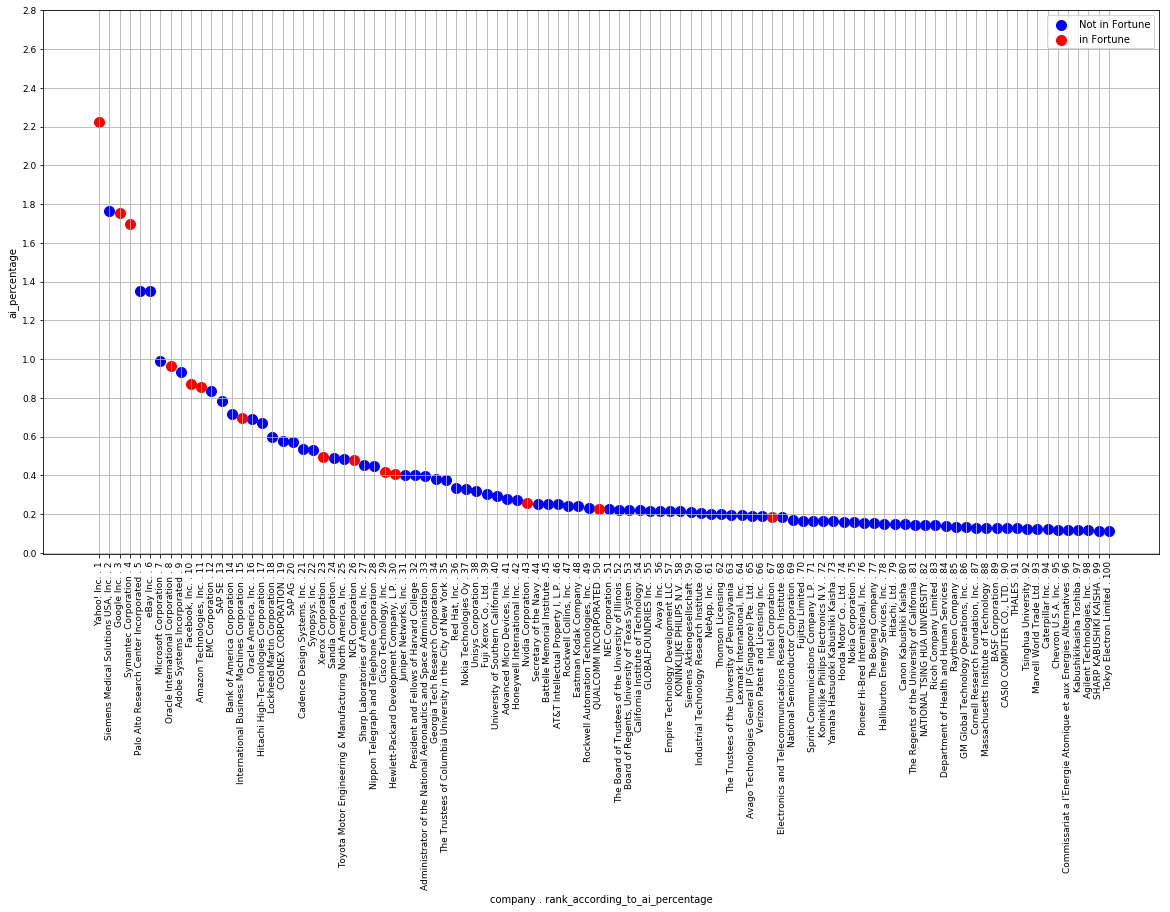

In [41]:
fig, ax = plt.subplots()
grouped = companies_to_visualize.groupby('color')
get_color = {"Not in Fortune":"blue" ,"in Fortune":"red"}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='company . rank_according_to_ai_percentage', y='ai_percentage',\
               label=key, color=get_color[key], figsize=(20,10), fontsize=9,\
               s=100, grid="on")

plt.yticks(np.arange(0.0, 3.0, 0.2))
plt.xticks(np.arange(1, 101, 1), rotation=90)    

labels = [item.get_text() for item in ax.get_xticklabels()]
for index, company in enumerate(list(companies_to_visualize.organization)):
    labels[index] = str(company) + " . " + str(index+1)
ax.set_xticklabels(labels)

plt.show()

From this figure we can see that companies that invested in AI research (which derived from proportion of AI patents they have) would be able to make it to the Fortune 500 list. As the AI research propotion decrease the companies chance of being a high rank company also decreases. We can see that there is only one company in the Fortune list with less than 0.2 AI patent percentage. This percentage corresponds to rank 50 in our list (as it is seen in the figure) and it means that all the technology companies (except one) in Fortune 500 list are from top 50 in the ranking we calculated by AI patent percentage.

Here is the complete list of top AI companies that made it to the Fortune list (which are red dots above).

In [42]:
merged_companies =\
    companies_to_visualize[["organization","ai_percentage"]].merge(top_fortune, on="organization")
merged_companies[["organization","ai_percentage"]]

,organization,ai_percentage
0,Yahoo! Inc.,2.222222
1,Google Inc.,1.753531
2,Symantec Corporation,1.698113
3,Oracle International Corporation,0.963206
4,"Facebook, Inc.",0.872093
5,"Amazon Technologies, Inc.",0.858086
6,International Business Machines Corporation,0.696951
7,Xerox Corporation,0.494671
8,NCR Corporation,0.477580
9,"Cisco Technology, Inc.",0.417436


Inspired from what Putin said, we also wanted check wheter or not having number of AI patents would actually, be beneficial strength of countries' defense industries.

### 8. Considering that Putin recently said “the nation that leads in AI will be the ruler of the world”, what is the relationship between number AI related patents and the rank of countries’ defense industry?

To be able to answer this question we need to have some kind of ranking for countries' defense industries. We though that using top 100 Global Defense companies list (made by Defense News  yearly) to extract the revenues along with the belonging countries of each defense company and then, grouping these companies by countries and summing up their revenues would give us a reasonable estimation for rankings of countries' defense industries.

First, we scraped the Defense News website to get required informations of companies in defense industry and put the information Pickle format.

In [ ]:
# Don't execute this cell, use the following saved pickle instead.
count = 0
current_country = str()
current_revenue = 0.0
country_revenues = dict()

f = open("data/top_defense.txt")

for line in f.readlines():
    if line.strip():
        if count % 2 == 0:
            current_country = line.strip("\n")
        elif count % 2 == 1:
            current_revenue =\
                line.replace(",","").strip("\n").strip("$").split(".")[0]
            if current_country in country_revenues:
                country_revenues[str(current_country)] += int(current_revenue)
            else:
                country_revenues[str(current_country)] = int(current_revenue)
        count += 1

pickle_out = open("data/country_revenues.pickle","wb")
pickle.dump(country_revenues, pickle_out)
pickle_out.close()

In [43]:
pickle_in = open("data/country_revenues.pickle","rb")
country_revenues = pickle.load(pickle_in)

In [44]:
country_revenues = pd.DataFrame(list(country_revenues.items()))
country_revenues.columns = ["country", "revenue_in_milions"]
country_revenues = country_revenues.sort_values(by='revenue_in_milions', ascending=False)
country_revenues.country = country_revenues.country.apply(lambda row: row.upper())
country_revenues.index =  range(1,len(country_revenues)+1)
country_revenues.head(10)

,country,revenue_in_milions
1,US,220693
2,GB,40529
3,FR,27931
4,RU,19428
5,IT,9832
6,JP,8664
7,IL,8615
8,KR,7650
9,IN,3682
10,DE,3421


These are the countries that are in the top defense industry list and their total revenues in million dollars. Similar to company analysis, only half of countries made it to the top 100 defense companies list and, since this is the case, we are not going to be able to compare all the countries we ordered (according AI patentes) with Defense News rankings. Consequently we decided to follow the same method as before and check which countries from our top list (based on AI patents) made it to the top 100 list of Defense News.

One other point to mention about our choice of implementation is that unlike companies, we are not going to use AI patents percentage for countries because we tried that and calculated percentages were not descriptive at all. There are some countries with very few patens which all related to AI and so, their AI patent percentage was very high. Unlike companies, there are very few countries with a lot of patents and a lot of countries with very few patens (as you can see in the [figure we draw](#country_patents)), pruning according to some number of patents doesn't work here. We only excluded United States and Japan to be able to demonstrate AI rankings of other countries more clearly.

Note that we already know both US and JP are on the top 100 Defense News list.

In [52]:
number_of_countries = len(country_year_df_copy)

top_ai_original = country_year_df_copy["total"].head(number_of_countries)
top_ai_original = pd.DataFrame(top_ai_original)
top_ai_original["country"] = country_year_df_copy.index
top_ai_original = top_ai_original.sort_values(by='total', ascending=False)

top_ai = top_ai_original.copy()

top_ai = top_ai[top_ai["country"] != "US"]
top_ai = top_ai[top_ai["country"] != "JP"]

top_ai.index = range(1,len(top_ai)+1)
top_ai = top_ai[["country","total"]]
top_ai.head(10)

,country,total
1,DE,133
2,KR,87
3,IL,66
4,CA,61
5,TW,61
6,FR,48
7,NL,46
8,GB,34
9,IE,24
10,IN,23


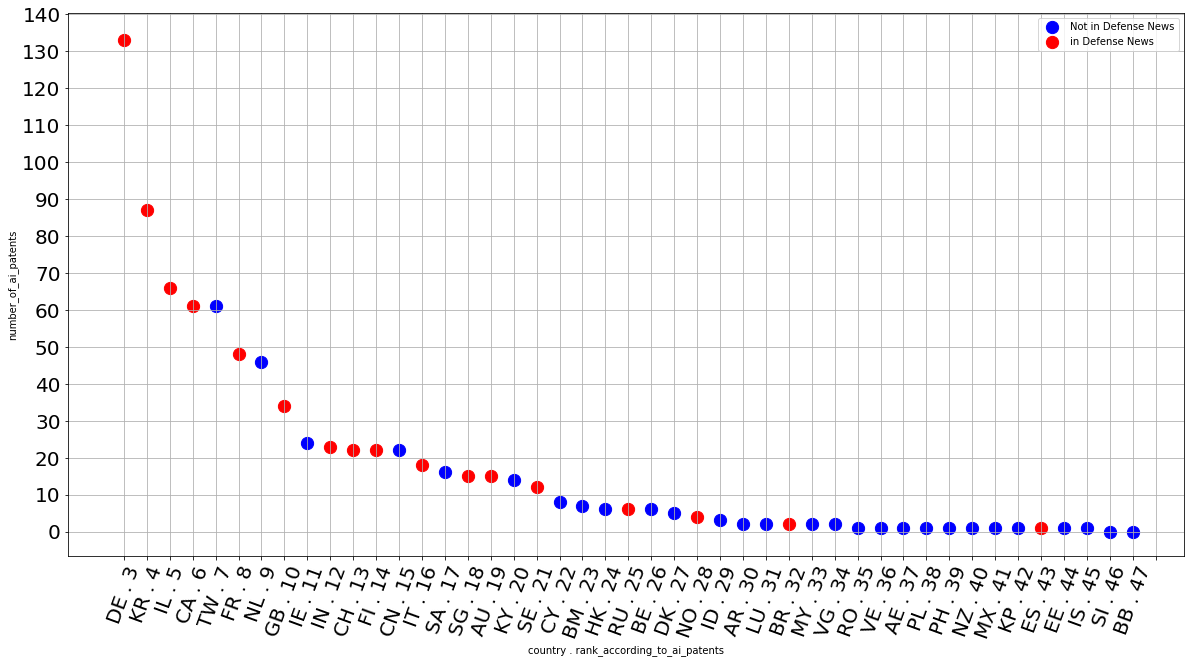

In [55]:
countries_to_visualize = top_ai[["country","total"]].copy()
countries_to_visualize.columns = ["country","number_of_ai_patents"]
countries_to_visualize["country . rank_according_to_ai_patents"] = top_ai.index
countries_to_visualize["color"] = countries_to_visualize["country"].\
    apply(lambda country:"in Defense News" if country in list(country_revenues.country) else "Not in Defense News")
countries_to_visualize  = countries_to_visualize.head(100)

fig, ax = plt.subplots()
grouped = countries_to_visualize.groupby('color')
get_color = {"Not in Defense News":"blue" ,"in Defense News":"red"}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='country . rank_according_to_ai_patents', y='number_of_ai_patents',\
               label=key, color=get_color[key], figsize=(20,10), fontsize=20,\
               s=150, grid="on")

plt.xticks(np.arange(1, 47, 1), rotation=70)    
plt.yticks(np.arange(0.0, 150, 10))

labels = [item.get_text() for item in ax.get_xticklabels()]
for index, country in enumerate(list(countries_to_visualize.country)):
    labels[index] = str(country) + " . " + str(index+3)
ax.set_xticklabels(labels)

plt.show()

Again, it is clear that countries that have more AI patents are likely to be in top 100 Defense News list. There are total of 47 countries present in the AI patent list and 16 of them were also present in top 100 Defense News list. And this figures shows that 13 of these 16 countries has more than 10 patents in AI. It can also be seen that out of top 20 countries in our list (based on AI patents), 15 countries were present in top 100 Defense News list as well. From the figure, the frequency of red dots (countries in top 100 Defense News) incrasing as the number of the AI patents increase.

So we can actually confirm that countries which are making more revenue from their companies in defense industry (meaning that contries which have bigger defense industries) is also the ones which have more AI patents. So as Putin stated, it seems that countries who invested in AI will be the  countries which have bigger and better defense industries. However, it also seems that Putin is not going to be able to rule the world:

In [59]:
top_ai_original = top_ai_original.rename(columns={'total': 'number_of_ai_patents',}) 
top_ai_original[top_ai_original.country.isin(["US","RU"])][["number_of_ai_patents"]]

,number_of_ai_patents
country,
US,4526
RU,6
